In [1]:
from shared import get_clean_data

#DATA_FILENAME = '/home/sami/py-graph/facebook_combined.txt.gz'
#DATA_FILENAME = '/home/sami/py-graph/fb_simple.txt.gz'
DATA_FILENAME = '/home/sami/py-graph/exampledata.txt.gz'

print("Normalizing data (or loaded pre-computed)")
edges, num_edges, num_nodes = get_clean_data(DATA_FILENAME, shuffle=False, save_readable=True)
print('\nEDGES SHAPE: {}'.format(edges.shape))

Normalizing data (or loaded pre-computed)
Parsing from zip. Will write to file /home/sami/py-graph/exampledata.txt-cleaned.npy
ORIGINAL DIST: 1.625 MIN: 0 MAX: 8

EDGES SHAPE: (16, 2)


In [2]:
%load_ext Cython
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
%%cython
import numpy as np
cimport cython
from shared import fixed_width_print

cdef int UNMAPPED = -1

def linear_deterministic_greedy(int[:,::] edges,
                                int num_nodes,
                                int num_partitions,
                                int[::] partition,
                                int[::] fixed):
    """
    This algorithm favors a cluster if it has many neighbors of a node, but
    penalizes the cluster if it is close to capacity.
    
    edges: An [:,2] array of edges.
    num_nodes: The number of nodes in the graph.
    num_partitions: How many partitions we are breaking the graph into.
    partition: The partition from a previous run. Used for restreaming.

    Returns: A new partition.
    """
    # The output partition

    if partition is None:
        partition = np.repeat(np.int32(UNMAPPED), num_nodes)
    if fixed is None:
        fixed = np.repeat(np.int32(UNMAPPED), num_nodes)
    elif len(partition) < num_nodes:
        print("THIS IS BAD AND MAY BREAK")
        print("len(partitions) = {}, num_nodes = {}".format(len(partition),num_nodes))

    cdef int[::] partition_sizes = np.zeros(num_partitions, dtype=np.int32)
         
    cdef int[::] partition_votes = np.zeros(num_partitions, dtype=np.int32)
    
    # Fine to be a little off, to stay integers
    cdef int partition_capacity = num_nodes / num_partitions
    
    cdef int last_left = edges[0,0]
    cdef int i = 0
    cdef int left = 0
    cdef int right = 0
    cdef int arg = 0
    cdef int max_arg = 0
    cdef int max_val = 0
    cdef int val = 0
    cdef int len_edges = len(edges)
    
    _print = False

    for i in range(len_edges):
        left = edges[i,0]
        right = edges[i,1]
    
        if last_left != left and fixed[last_left] != UNMAPPED:
            if _print:
                print("Skipping node {}".format(last_left))
            partition_votes[:] = 0
            last_left = left
            continue
            
        if last_left != left:
            # We have found a new node so assign last_left to a partition

            # Calculate available space in each partition, multiply that by partition_votes to get max_val
            #max_arg: most likely partition asssignment, ie. the partition with enough space available
            #         and the highest number of edges (relationships to other nodes)
            #max_val: current highest value of votes against remaining capacity
            #partition_votes: the number of right nodes in a partition related to current left node

            if _print:
                print("Assigning node {}".format(last_left))
            
            max_arg = 0
            max_val = (partition_votes[0]) * (
                       partition_capacity - partition_sizes[0])
            if _print:
                print("\tP{} = {} x ({} - {}) = {}".format(0,
                                                           partition_votes[0],
                                                           partition_capacity,
                                                           partition_sizes[0],
                                                           max_val))

            for arg in range(1, num_partitions):
                val = (partition_votes[arg]) * (
                       partition_capacity - partition_sizes[arg])
                
                if _print:
                    print("\tP{} = {} x ({} - {}) = {}".format(arg,
                                                               partition_votes[arg],
                                                               partition_capacity,
                                                               partition_sizes[arg],
                                                               val))
                if val > max_val:
                    max_arg = arg
                    max_val = val

            if max_val == 0:
                max_arg = arg
                # No neighbors (or multiple maxed out) so "randomly" select
                # the smallest partition
                for arg in range(i % num_partitions, num_partitions):
                    if partition_sizes[arg] < partition_capacity:
                        max_arg = arg
                        max_val = 1
                        break
                if max_val == 0:
                    for arg in range(0, i % num_partitions):
                        if partition_sizes[arg] < partition_capacity:
                            max_arg = arg
                            break


                            
            partition_sizes[max_arg] += 1
            partition[last_left] = max_arg
            #fixed[last_left] = 1
            partition_votes[:] = 0
            last_left = left

            if _print:
                fixed_width_print(np.asarray(partition))
                fixed_width_print(np.asarray(fixed))
            
        if partition[right] != UNMAPPED:
            partition_votes[partition[right]] += 1

    # Clean up the last assignment    
    if _print:
        print("last one")

    max_arg = 0
    max_val = 0
    for arg in range(0, num_partitions):
        if partition_sizes[arg] < partition_capacity:
            val = (partition_votes[arg]) * (
                    1 - partition_sizes[arg] / partition_capacity)
            
            if _print:
                print("\tP{} = {} x (1 - {} / {}) = {}".format(arg,
                                                               partition_votes[arg],
                                                               partition_sizes[0],
                                                               partition_capacity,
                                                               val))
            
            if val > max_val:
                max_arg = arg
                max_val = val

    partition[left] = max_arg
    fixed[left] = 1

    return (np.asarray(partition), np.asarray(fixed))

In [4]:
from shared import fixed_width_print

assignments = None
fixed = None

# Order of people arriving
arrivals = [4, 6, 7, 1, 2, 0, 3, 5, 8]
#arrivals = range(0, 9)

# run first pass - this is our initial seed
assignments, fixed = linear_deterministic_greedy(edges, num_nodes, 4, assignments, fixed)

print("Initial assignment seed:")
fixed_width_print(assignments)
fixed_width_print(fixed)
print("\n")

print("People start arriving:")
for a in arrivals:
    fixed_width_print(assignments)
    fixed_width_print(fixed)    
    
    print("Person {} -> shelter {}".format(a, assignments[a]))
    fixed[a] = 1
    
    # restream non-fixed assignments
    assignments, fixed = linear_deterministic_greedy(edges, num_nodes, 4, assignments, fixed)

fixed_width_print(assignments)
fixed_width_print(fixed)

#assignments, fixed = linear_deterministic_greedy(edges, num_nodes, 4, assignments, fixed)
#print(assignments)
#print(fixed)
#print("\n")

Initial assignment seed:
[ 3  3  0  0  1  1  2  2  0]
[-1 -1 -1 -1 -1 -1 -1 -1  1]


People start arriving:
[ 3  3  0  0  1  1  2  2  0]
[-1 -1 -1 -1 -1 -1 -1 -1  1]
Person 4 -> shelter 1
[ 0  0  1  1  1  2  2  3  3]
[-1 -1 -1 -1  1 -1 -1 -1  1]
Person 6 -> shelter 2
[ 1  1  0  0  1  2  2  3  3]
[-1 -1 -1 -1  1 -1  1 -1  1]
Person 7 -> shelter 3
[ 0  0  1  1  1  2  2  3  0]
[-1 -1 -1 -1  1 -1  1  1  1]
Person 1 -> shelter 0
[ 1  0  1  0  1  2  2  3  0]
[-1  1 -1 -1  1 -1  1  1  1]
Person 2 -> shelter 1
[ 0  0  1  1  1  1  2  3  0]
[-1  1  1 -1  1 -1  1  1  1]
Person 0 -> shelter 0
[ 0  0  1  0  1  1  2  3  0]
[ 1  1  1 -1  1 -1  1  1  1]
Person 3 -> shelter 0
[ 0  0  1  0  1  1  2  3  0]
[ 1  1  1  1  1 -1  1  1  1]
Person 5 -> shelter 1
[ 0  0  1  0  1  1  2  3  0]
[ 1  1  1  1  1  1  1  1  1]
Person 8 -> shelter 0
[ 0  0  1  0  1  1  2  3  0]
[ 1  1  1  1  1  1  1  1  1]


In [5]:
from shared import line_print

fn = set([x[0] for x in edges])
file_nodes = []
for f in fn:
    file_nodes.append(f)

def slice_data(edges, node):
    # XXX: this can certainly be optimised using memoryviews
    
    # initialise left node to first item in edge list
    left = edges[0][0]
    edges_slice = []
    node += 1

    for e in edges:
        if left != e[0]:
            left = e[0]

        if left > node:
            break
            
        edges_slice.append(e)

    if not edges_slice:
        return np.zeros((1, 2), dtype=np.int32)
    
    return np.asarray(edges_slice)

assignments = None
fixed = None
for node in file_nodes:
    e = slice_data(edges, node)
    assignments, fixed = linear_deterministic_greedy(e, num_nodes, 4, assignments, fixed)
    fixed_width_print(assignments)
    fixed_width_print(fixed)

    #print("NODE:{}".format(node))
    #line_print(assignments)
    print()

[ 3  3 -1 -1 -1 -1 -1 -1 -1]
[-1  1 -1 -1 -1 -1 -1 -1 -1]

[ 3  3  0 -1 -1 -1 -1 -1 -1]
[-1  1  1 -1 -1 -1 -1 -1 -1]

[ 0  3  0  0 -1 -1 -1 -1 -1]
[-1  1  1  1 -1 -1 -1 -1 -1]

[ 0  3  0  0  0 -1 -1 -1 -1]
[-1  1  1  1  1 -1 -1 -1 -1]

[ 0  3  0  0  0  0 -1 -1 -1]
[-1  1  1  1  1  1 -1 -1 -1]

[ 0  3  0  0  0  0  0 -1 -1]
[-1  1  1  1  1  1  1 -1 -1]

[ 0  3  0  0  0  0  0  0 -1]
[-1  1  1  1  1  1  1  1 -1]

[ 0  3  0  0  0  0  0  0  0]
[-1  1  1  1  1  1  1  1  1]

[ 0  3  0  0  0  0  0  0  0]
[-1  1  1  1  1  1  1  1  1]



In [6]:
def draw_figures(waste_values, edge_score_values, num_partitions):
    fig, axes = plt.subplots(nrows=1, ncols=2)
    
    (waste_axes, score_axes) = axes
    waste_axes.plot(waste_values, 'r')
    waste_axes.set_xlabel('Round')
    waste_axes.set_ylabel('Number of wasted bins')
    waste_axes.set_ylim(bottom=0)
    waste_axes.set_title('Wasted Bins: {} partitions'.format(num_partitions))
    
    score_axes.plot(edge_score_values, 'r')
    score_axes.set_xlabel('Round')
    score_axes.set_ylabel('Ratio of edges crossing partitions')
    score_axes.set_ylim(bottom=0)
    score_axes.set_title('Score: {} partitions'.format(num_partitions))
    
    fig.tight_layout()

In [7]:
from shared import score

def run_restreaming_greedy(edges, num_nodes, num_partitions=10, num_iterations=10):
    print('\n{} PARTITIONS'.format(num_partitions))
    assignments = None
    fixed = None
    print('ROUND\tWASTE\tSCORE\tCUT')
    waste_values = []
    edge_score_values = []
    flipped_edges = numpy.flipud(edges).copy()

    for i in range(num_iterations):
        assignments, fixed = linear_deterministic_greedy(edges, num_nodes, num_partitions, assignments, fixed)
        (waste, edge_score, edges_cut) = score(assignments, edges)
        waste_values.append(waste)
        edge_score_values.append(edge_score)
        print('{}\t{:0.3f}\t{:0.3f}\t{}'.format(i, waste, edge_score, edges_cut))

    draw_figures(waste_values, edge_score_values, num_partitions)
    return assignments


4 PARTITIONS
ROUND	WASTE	SCORE	CUT
0	0.333	0.750	12
1	0.333	0.750	12
2	0.333	0.500	8
3	0.333	0.625	10
4	0.333	0.625	10
5	0.333	0.500	8
6	0.333	0.625	10
7	0.333	0.625	10
8	0.333	0.500	8
9	0.333	0.625	10
10	0.333	0.625	10
11	0.333	0.500	8
12	0.333	0.625	10
13	0.333	0.625	10
14	0.333	0.500	8
CPU times: user 133 ms, sys: 7.59 ms, total: 141 ms
Wall time: 136 ms

20 PARTITIONS
ROUND	WASTE	SCORE	CUT
0	16.778	0.125	2
1	16.778	0.125	2
2	16.778	0.125	2
3	16.778	0.125	2
4	16.778	0.125	2
5	16.778	0.125	2
6	16.778	0.125	2
7	16.778	0.125	2
8	16.778	0.125	2
9	16.778	0.125	2
10	16.778	0.125	2
11	16.778	0.125	2
12	16.778	0.125	2
13	16.778	0.125	2
14	16.778	0.125	2
CPU times: user 111 ms, sys: 0 ns, total: 111 ms
Wall time: 111 ms


array([19, 19, 19, 19, 19, 19, 19, 19,  0], dtype=int32)

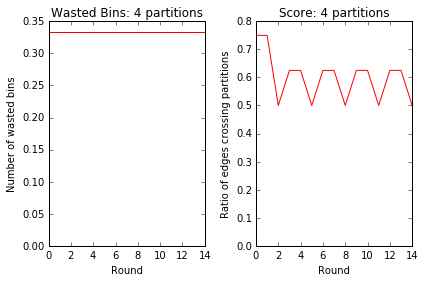

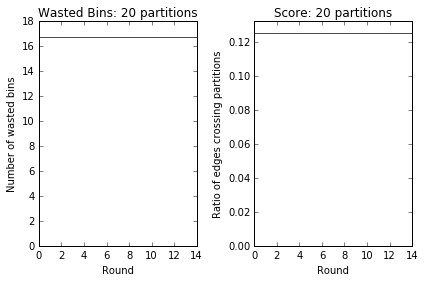

In [8]:
# Use the greedy method to break into 4 partitions
%time run_restreaming_greedy(edges, num_nodes, num_partitions=4, num_iterations=15)

# Use the greedy method to break into 20 partitions
%time run_restreaming_greedy(edges, num_nodes, num_partitions=20, num_iterations=15)